In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch

from train import train_MSAP
from dist_matrix import gen_dist_matrix

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15

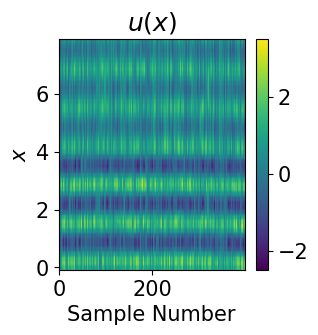

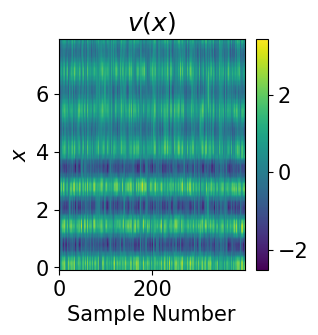

In [2]:
turing = np.load("data/turing.npz")

data = turing["data"]
eta = turing["params"].T[0]

plt.figure(figsize=(3, 3))
plt.subplot()
plt.imshow(data[0,:,::2].T, aspect='auto', origin='lower')
plt.xlabel('Sample Number')
plt.ylabel('$x$')
plt.yticks([0,12.5, 25, 37.5],[0, 2, 4, 6])
plt.colorbar()
plt.title("$u(x)$")
plt.savefig("graphs/turing_traj_u.pdf")

plt.figure(figsize=(3, 3))
plt.subplot()

plt.imshow(data[0,:,1::2].T, aspect='auto', origin='lower')
plt.xlabel('Sample Number')
plt.ylabel('$x$')
plt.yticks([0,12.5, 25, 37.5],[0, 2, 4, 6])
plt.colorbar()
plt.title("$v(x)$")
plt.savefig("graphs/turing_traj_v.pdf")

plt.show()

In [3]:
# data = StandardScaler().fit_transform(data.reshape(data.shape[0] * data.shape[1], -1)).reshape(data.shape)
# dmat = gen_dist_matrix(data, name="data/turing", norm=True)
dmat = np.load("data/turing_dmat.npz")["dmat"]

valid_size = len(dmat) // 5
train_size = len(dmat) - valid_size

train_idx, valid_idx = train_test_split(torch.arange(len(dmat)), test_size=valid_size)

dmat = torch.tensor(dmat, dtype=torch.float32)
train_dmat = dmat[train_idx[:, None], train_idx[None, :]]
valid_dmat = dmat[valid_idx[:, None], train_idx[None, :]]

In [ ]:
cfg = {
    "target_dim": 10,
    "intermediate_dim": 16,
    "intermediate_layers": 3,
}

models_t, losses_t = train_MSAP(train_dmat, valid_dmat, cfg, "turing", min_delta=0.1, patience=50, project_name="MSAP", N_inits=2)

In [ ]:
cfg = {
    "target_dim": 10,
    "intermediate_dim": 16,
    "intermediate_layers": 3,
    "periodic1d": True,
}

models_t_, losses_t_ = train_MSAP(train_dmat, valid_dmat, cfg, "turing_periodic1d", min_delta=0.1, patience=50, N_inits=2, N_latent=1)

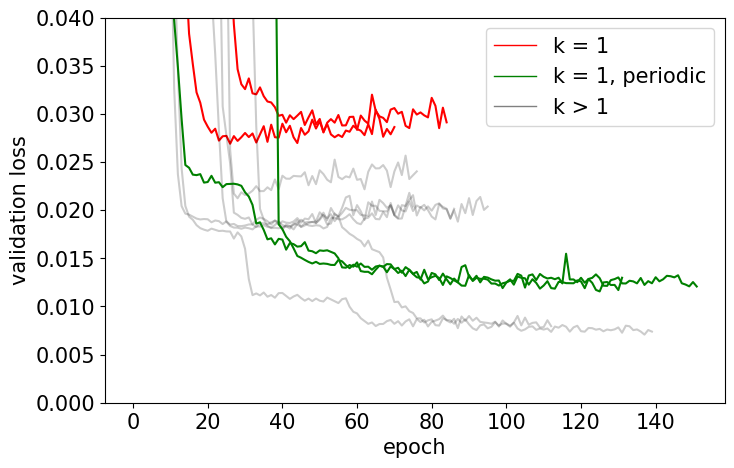

In [13]:
# to plot this graph you have to download the validation loss data from the wandb to the data folder


import pandas as pd
from matplotlib.lines import Line2D

learning_curves = pd.read_csv("data/turing_learning_curves.csv")

plt.figure(figsize=(8, 5))
epoch = learning_curves["epoch"]
for i in range(1, 5):
    c = "red" if i == 1 else "black"
    alpha = 1 if i == 1 else 0.2
    for init in range(1, 3):
        valid_loss = learning_curves[f"turing; latent_dim: {i}, init #{init} - valid_loss"]
        plt.plot(epoch, valid_loss, c=c, alpha=alpha)

for init in range(1, 3):
    valid_loss = learning_curves[f"turing_periodic1d; latent_dim: {1}, init #{init} - valid_loss"]
    plt.plot(epoch, valid_loss, c="green")

custom_lines = [Line2D([0], [0], color="red", lw=1),
                Line2D([0], [0], color="green", lw=1),
                Line2D([0], [0], color="gray", lw=1)]

plt.legend(custom_lines, ["k = 1", "k = 1, periodic", "k > 1"])

plt.ylim(0, 0.04)

plt.xlabel("epoch")
plt.ylabel("validation loss")

plt.savefig("graphs/turing_learning_curves.pdf")

plt.show()

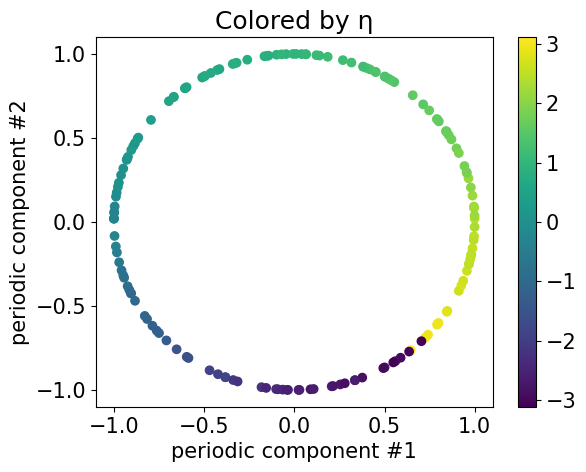

In [7]:
def normalize(x):
    return x / (x ** 2).sum(axis=-1, keepdims=True) ** 0.5

plt.scatter(*normalize(models_t_[0].latent.cpu().detach()).T, c=eta[train_idx])
plt.xlabel("periodic component #1")
plt.ylabel("periodic component #2")
plt.title("Colored by η")
plt.colorbar()

plt.savefig("graphs/turing_latent.pdf")